
<h1 style="font-size: 180%">Single-mixed refrigerant (SMR) natural gas liquefaction process simulation optimization <a href="https://doi.org/10.1016/j.ces.2021.116699" title="SMR optimization paper">[1]</a> </h1>

<hr>

<h2 style="font-size: 150%">SMR process description</h2>

<spam style="font-size: 120%">The single-mixed refrigerant natural gas liquefaction process consists of using a multi-component refrigerant operating in a refrigeration cycle to produce heat sink to cool down and liquefy the natural gas stream, as illustrated in the figure below. The refrigeration cycle includes a four-stage compression system with intermediate cooling and phase separation for possible condensate. The liquid phase is compressed in pumps and the vapor phase in the compressors. No phase mixing is considered, which means that the refrigerant heavy condensate is mixed together and goes through the hot pass in the multi-stream heat exchanger separately from the light vapor phase. Then, the streams are mixed back together in the cold pass inside the cryogenic heat exchanger as they vaporize.</spam>

<br/>
<br/>
<img src="SMR_LNG/pfd_smr.png" alt="process flow diagram image" style="height: 400px"/>
<br/>
<br/>

<h2 style="font-size: 150%"> SMR process simulation</h2>

<spam style="font-size: 120%">The described single-mixed refrigerant natural gas liquefaction process is rather difficult to model and simulate mainly because it involves Pinch-like calculations in each multi-stream heat exchangers (MSHE) considering phase change, cryogenic conditions, and non-ideal mixtures. In other words, these heat exchangers are discretized in temperature segments, where vapor-liquid equilibrium calculations are performed to determine the temperature of every stream and, therefore, the temperature profiles in these operation units. For the sake of process feasibility considering the Second Law of Thermodynamics, the temperatures of hot streams have to be effectively higher than the cold ones throughout the heat exchangers.
For rigorous calculations, this process is modeled and simulated in DWSIM v7.0 using Peng-Robinson equation of state, which is appropriate for hydrocarbons mixtures, such as the natural gas and the refrigerant mixtures. The minimum internal temperature approach is calculated using the Python Script in DWSIM. See the simulation ``SMR_2exp_phaseSep_MSHE_MITApy.dwxmz`` for more details.</spam>

<br />
<br />
<img src="SMR_LNG/pfd_smr_dwsim.png" alt="process flow diagram image" style="height: 400px"/>
<br />
<br />

<h2 style="font-size: 150%">SMR process optimization problem</h2>

<spam style="font-size: 120%">Knowing that the work consumption is the most relevant spending in the natural gas liquefaction process, then the design problem is to find $\textbf{x}^*\in \mathbb{R}^n$ that minimizes the following optimization problem</spam>

<spam style="font-size: 120%">

$$ \min_{\textbf{x}\in \mathcal{D}}\ \ f(\textbf{x})=\frac{\sum_{p\in PM}{W_p(\textbf{x})}}{\dot{m}_{NG}} $$
$$ \text{s.t.} \ \ g(\textbf{x})=3 - MITA(\textbf{x})\le 0$$
$$ \mathcal{D}=[\textbf{x}^{lb},\ \textbf{x}^{ub}], $$
</spam>

<spam style="font-size: 120%"> in which, for a given $\textbf{x}$, $W_p(\textbf{x})$ is the work consumption of the pressure manipulator unit $p$ in the set of compressors and pumps $PM$, $MITA(\textbf{x})$ is the minimum internal temperature approach in the MSHEs, $\mathcal{D}$ is a box constraint for the decision variables bounded by $\textbf{x}^{lb}$ and $\textbf{x}^{ub}$, and $\dot{m}_{LNG}$ is the mass flow rate of the natural gas stream. Therefore, the objective function $f$ in this optimization problem is the specific work consumed in the refrigeration cycle with respect to the mass flow rate of liquefied natural gas (LNG). Notice that the value of $W_p(\textbf{x})$ as well as $MITA(\textbf{x})$ are obtained in the black-box chemical process simulator, and so are $f(\textbf{x})$ and $g(\textbf{x})$. Then, $f(\textbf{x})$ and $g(\textbf{x})$ are known only at sampled points and make the optimization problem equivalent to equation above.</spam>

In [1]:
import numpy as np
from pprint import pprint
import os
from pathlib import Path

dir_path = str(Path(os.getcwd()).parent.absolute())

from dwsimopt.solve_sim_opt import OptimiSim

In [2]:
# Loading DWSIM simulation into Python (Simulation object)
sim_smr = OptimiSim(path2sim= os.path.join(dir_path, "examples\\SMR_LNG\\SMR_energy_recycle.dwxmz"), 
                    path2dwsim = "C:\\Users\\lfsfr\\AppData\\Local\\DWSIM8\\",
                    savepath = os.path.join(dir_path, "examples\\SMR_LNG\\SMR_energy_recycle2.dwxmz"),
                    init_dwsim=True)

added refs
Simulation was loaded successfully


In [3]:
from dwsimopt.py2dwsim import * 

# Assign DoF:
create_pddx( ["MR-1", "CompoundMassFlow", "Nitrogen", "kg/s"],    sim_smr, element="dof" )
create_pddx( ["MR-1", "CompoundMassFlow", "Methane", "kg/s"],     sim_smr, element="dof" )
create_pddx( ["MR-1", "CompoundMassFlow", "Ethane", "kg/s"],      sim_smr, element="dof" )
create_pddx( ["MR-1", "CompoundMassFlow", "Propane", "kg/s"],     sim_smr, element="dof" )
create_pddx( ["MR-1", "CompoundMassFlow", "Isopentane", "Pa"],    sim_smr, element="dof" )
create_pddx( ["VALV-01", "OutletPressure", "Mixture", "Pa"],      sim_smr, element="dof" )
create_pddx( ["COMP-4", "OutletPressure", "Mixture", "Pa"],       sim_smr, element="dof" )
create_pddx( ["COOL-08", "OutletTemperature", "Mixture", "K"],    sim_smr, element="dof" )

# Assign F
create_pddx( ["Sum_W", "EnergyFlow", "Mixture", "kW"], sim_smr, element="fobj" )

# adding constraints (g_i <= 0):
g1 = create_pddx( ["MITA1-Calc", "OutputVariable", "mita", "°C"], sim_smr, element="constraint", assign=False )
assign_pddx( lambda: 3-g1[0]() , ["MITA1-Calc", "OutputVariable", "mita", "°C"], sim_smr, element="constraint" )
g2 = create_pddx( ["MITA2-Calc", "OutputVariable", "mita", "°C"], sim_smr, element="constraint", assign=False )
assign_pddx( lambda: 3-g2[0]() , ["MITA2-Calc", "OutputVariable", "mita", "°C"], sim_smr, element="constraint" )
# assign_pddx( lambda: 3 - min(g2[0](),g1[0]()), ["MITA_Overall", "OutputVariable", 'mita', "°C"], sim_smr, element="constraint" )


pprint(vars(sim_smr))

Successfully added to <dwsimopt.solve_sim_opt.OptimiSim object at 0x000001ED431E7A30> a dof pddx function for CompoundMassFlow of Nitrogen (if applicable) from MR-1 in kg/s (if applicable)
Successfully added to <dwsimopt.solve_sim_opt.OptimiSim object at 0x000001ED431E7A30> a dof pddx function for CompoundMassFlow of Methane (if applicable) from MR-1 in kg/s (if applicable)
Successfully added to <dwsimopt.solve_sim_opt.OptimiSim object at 0x000001ED431E7A30> a dof pddx function for CompoundMassFlow of Ethane (if applicable) from MR-1 in kg/s (if applicable)
Successfully added to <dwsimopt.solve_sim_opt.OptimiSim object at 0x000001ED431E7A30> a dof pddx function for CompoundMassFlow of Propane (if applicable) from MR-1 in kg/s (if applicable)
Successfully added to <dwsimopt.solve_sim_opt.OptimiSim object at 0x000001ED431E7A30> a dof pddx function for CompoundMassFlow of Isopentane (if applicable) from MR-1 in Pa (if applicable)
Successfully added to <dwsimopt.solve_sim_opt.OptimiSim obj

In [4]:
# Setup for optimization
# Initial guess of optimization
x0 = np.array( [0.25/3600, 0.70/3600, 1.0/3600, 1.10/3600, 1.80/3600, 2.50e5, 50.0e5, -60+273.15] )

# decision variables bounds
bounds = np.array( [0.75*np.asarray(x0), 1.25*np.asarray(x0)] )   # 50 % around base case
bounds[0][-1] = 153     # precool temperature low limit manually
bounds[1][-1] = 253     # precool temperature upper limit manually

xlo = bounds[0]
xup = bounds[1]

test_at_x0 = True
if test_at_x0:
    # Testing for simulation at x0
    sim_smr.calculate_optProblem(1.0*x0)
    print(sim_smr.x_val,
        sim_smr.f_val,
        sim_smr.g_val)

    # Test saving simulation at x0 in 'savepath'
    sim_smr.interface.SaveFlowsheet(sim_smr.flowsheet,sim_smr.savepath,True)

    # Inspecting simulation object
    pprint(vars(sim_smr))

opt_functions calculation at x = [6.94444444e-05 1.94444444e-04 2.77777778e-04 3.05555556e-04
 5.00000000e-04 2.50000000e+05 5.00000000e+06 2.13150000e+02]
               Simulation converged in 3 iterations
f = [0.3891044], g = [-1.78887878 -3.47846713] at x = [6.94444444e-05 1.94444444e-04 2.77777778e-04 3.05555556e-04
 5.00000000e-04 2.50000000e+05 5.00000000e+06 2.13150000e+02]
[6.94444444e-05 1.94444444e-04 2.77777778e-04 3.05555556e-04
 5.00000000e-04 2.50000000e+05 5.00000000e+06 2.13150000e+02] [0.3891044] [-1.78887878 -3.47846713]
{'dof': array([[<function _toDwsim.<locals>.<lambda> at 0x000001ED435AB550>,
        'MR-1', 'CompoundMassFlow', 'Nitrogen', 'kg/s'],
       [<function _toDwsim.<locals>.<lambda> at 0x000001ED430943A0>,
        'MR-1', 'CompoundMassFlow', 'Methane', 'kg/s'],
       [<function _toDwsim.<locals>.<lambda> at 0x000001ED43094940>,
        'MR-1', 'CompoundMassFlow', 'Ethane', 'kg/s'],
       [<function _toDwsim.<locals>.<lambda> at 0x000001ED430949D0>,
  

Starting global optimization
Iter: 0, Best fit: [12757.55894964] at [8.68055556e-05 2.43055556e-04 2.62887401e-04 2.56675014e-04
 3.93090207e-04 2.63236720e+05 5.80826565e+06 2.16803580e+02]
Iter: 1, Best fit: [12757.55894964] at [8.68055556e-05 2.43055556e-04 2.62887401e-04 2.56675014e-04
 3.93090207e-04 2.63236720e+05 5.80826565e+06 2.16803580e+02]
Iter: 2, Best fit: [12757.55894964] at [8.68055556e-05 2.43055556e-04 2.62887401e-04 2.56675014e-04
 3.93090207e-04 2.63236720e+05 5.80826565e+06 2.16803580e+02]
PSO finished with x* = [8.68055556e-05 2.43055556e-04 2.62887401e-04 2.56675014e-04
 3.93090207e-04 2.63236720e+05 5.80826565e+06 2.16803580e+02]
fobj = 0.4295628230071346
g_0 = 12.757128997841448
g_1 = -4.156414327926981


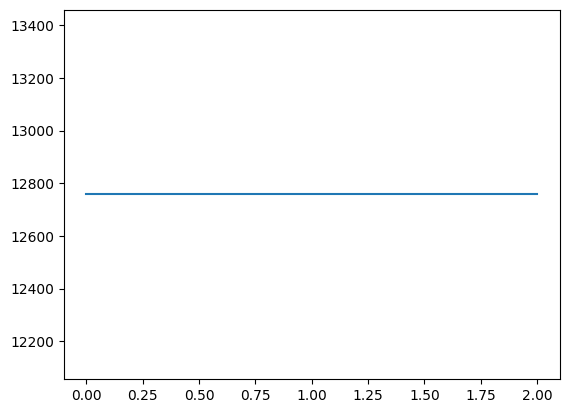

In [10]:
# Global optimization with PSO
sim_smr.verbose = False
results_PSO = sim_smr.PSO(x0, xlo, xup, pop=1, max_ite=3)


Starting global optimization
GA finished with x* = [7.74285171e-05 1.87744379e-04 2.28756174e-04 2.96039597e-04
 5.75732601e-04 1.90810083e+05 5.63177166e+06 2.02405444e+02]
fobj = self.f[0]()
g_0 = -1.261998517045896
g_1 = -7.006662930327906


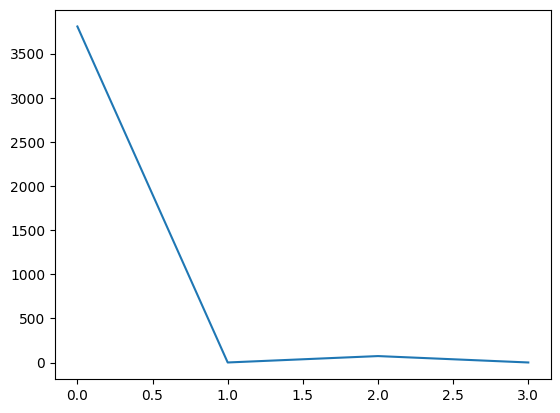

In [6]:
# Global optimization with GA
sim_smr.verbose = False
results_GA = sim_smr.GA(x0, xlo, xup, pop=2, max_ite=2, prob_mut=0.2)

Starting global optimization
DE finished with x* = [6.91781886e-05 2.34795550e-04 2.22827338e-04 3.24194977e-04
 4.76618247e-04 2.40244379e+05 5.06769715e+06 2.04463165e+02]
fobj = self.f[0]()
g_0 = -0.9565490625026882
g_1 = -3.8813981632377477


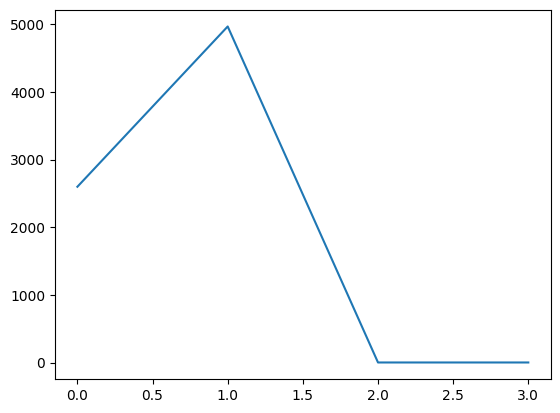

In [8]:
# Global optimization with DE
sim_smr.verbose = False
results_DE = sim_smr.DE(x0, xlo, xup, pop=2, max_ite=2)

In [5]:
# Global optimization with AFSA
sim_smr.verbose = False
results_AFSA = sim_smr.AFSA(x0, pop=1, max_ite=2, max_try_num=2, step=0.1, visual=0.3, q=0.98, delta=0.1)

[AggregateException('One or more errors occurred.')] at x = [0.75892758 0.26153831 0.04344421 0.51354265 0.39566519 0.61509229
 0.16145256 0.79263786]
[AggregateException('One or more errors occurred.')] at x = [0.49931556 0.55844499 0.01150119 0.76655272 0.56216835 0.8013662
 0.03247796 0.60943501]
[AggregateException('One or more errors occurred.')] at x = [0.73579887 0.28798958 0.04059842 0.53608319 0.41049887 0.63168734
 0.14996228 0.77631641]
[AggregateException('One or more errors occurred.')] at x = [ 0.45803011  0.10445966 -0.21982655  0.312288    0.55738955  0.77993615
  0.13155723  1.04020815]
[AggregateException('One or more errors occurred.')] at x = [ 0.87982717  0.02795725 -0.14626246  0.74855392  0.36490635  0.7026445
  0.35821464  0.50110911]
[AggregateException('One or more errors occurred.')] at x = [ 0.44680413  0.27995862 -0.02181622  0.4293236   0.46356453  0.67845603
  0.02043134  0.95277102]
[AggregateException('One or more errors occurred.')] at x = [ 0.21964501

In [16]:
results_PSO